In [1]:

import os
from collections import defaultdict

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
import pandas as pd
import timm
import torch
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from timm import create_model
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#open datasets/public_data.parquet
df = pd.read_parquet('datasets/public_data.parquet', engine='pyarrow')

In [5]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (ConvNeXt input size)
    transforms.ToTensor(),  # Convert the image to a tensor
])


In [7]:
path = "datasets/content/drive/MyDrive/Makarov-Olymp/Images/"
def load_images_to_tensor(df, transform):
    images = []
    labels = []
    for _, row in df.iterrows():
        result_path = path + row['image'].split('/')[-1]
        img = Image.open(result_path).convert('RGB')  # Open and ensure RGB format
        img = transform(img)                         # Apply transformations
        images.append(img)
        labels.append(row['label'])
    return torch.stack(images), torch.tensor(labels)



In [8]:
X_train, Y_train = load_images_to_tensor(train_df, transform)
X_test, Y_test = load_images_to_tensor(test_df, transform)
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

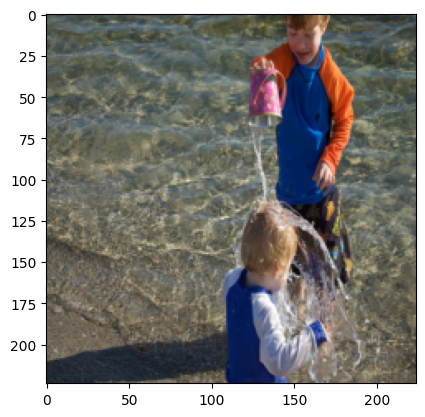

In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1].permute(1, 2, 0).cpu().numpy())

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([14220, 3, 224, 224])
torch.Size([14220])
torch.Size([1581, 3, 224, 224])
torch.Size([1581])


Image batch shape: torch.Size([16, 3, 224, 224]), Label batch shape: torch.Size([16])
Image pixel range: 0.0 to 0.9843137264251709


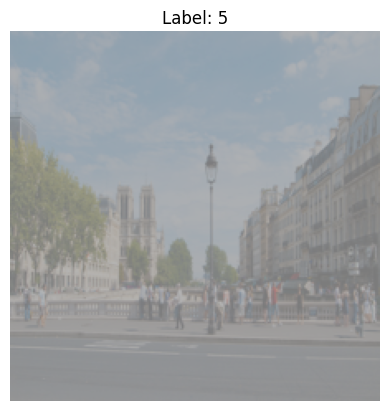

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        """
        Custom dataset for applying transformations to images.
        
        Args:
            X (Tensor): Input features (images), shape (N, C, H, W).
            Y (Tensor): Labels corresponding to the images.
            transform (callable, optional): Transformations to be applied.
        """
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx].cpu().permute(1, 2, 0).numpy()  # Convert tensor to (H, W, C) NumPy array
        label = self.Y[idx]
        
        if self.transform:
            # Convert NumPy array to PIL Image
            image = transforms.functional.to_pil_image(image)
            image = self.transform(image)
        return image, label

# Define transformations using torchvision for train and test datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),  # Color jitter
    transforms.GaussianBlur(kernel_size=3),  # Gaussian blur
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')  # Random erasing
])


test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize to fixed size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Create datasets (X_train, Y_train, X_test, Y_test assumed to be PyTorch tensors)
train_dataset = CustomDataset(X_train, Y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, Y_test, transform=test_transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage: visualize a batch of images
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}, Label batch shape: {labels.shape}")
    print(f"Image pixel range: {images[0].min().item()} to {images[0].max().item()}")
    
    # Visualize the first image in the batch
    img = images[0].permute(1, 2, 0).numpy()  # Convert tensor to (H, W, C) for display
    img = (img * 0.229 + 0.485).clip(0, 1)  # Undo normalization for visualization
    plt.imshow(img)
    plt.title(f"Label: {labels[0].item()}")
    plt.axis("off")
    plt.show()
    break


In [12]:
import torch
import torch.nn as nn
import timm

# Assuming you have your Y_train defined and device set up
num_classes = len(Y_train.unique()) if Y_train.ndim == 1 else Y_train.size(1)

# Initialize the model
model = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for param in model.get_classifier().parameters():
    param.requires_grad = True

# Create a new model that includes additional layers
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        # Add additional layers here (e.g., a fully connected layer followed by dropout)
        self.additional_layers = nn.Sequential(
            nn.Linear(num_classes, 512),  # Adjust input size as necessary
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Final output layer
        )

    def forward(self, x):
        x = self.base_model(x)  # Get output from ConvNeXt
        x = self.additional_layers(x)  # Pass through additional layers
        return x

# Instantiate the custom model
custom_model = CustomModel(model)
custom_model.to(device)

# Now you can define your optimizer, criterion, and training loop.


CustomModel(
  (base_model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (co

In [26]:
for param in model.parameters():
    param.requires_grad = True

# Unfreeze the classifier layer
for param in model.get_classifier().parameters():
    param.requires_grad = True

In [24]:
# Cross-Entropy Loss for classification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#calculate class weights

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [29]:
print(class_weights)

tensor([1.6494, 0.7575, 1.5691, 1.4699, 1.0274, 0.5894, 0.8560, 0.6961, 1.0450,
        1.9083])


In [14]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(y_true, y_pred):
    """Compute accuracy and F1 macro, as well as F1 by class."""
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_by_class = f1_score(y_true, y_pred, average=None)  # F1 score for each class
    
    return accuracy, f1_macro, f1_by_class


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with tqdm(dataloader, desc="Training", unit="batch") as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)

            # Store predictions and true labels for metrics
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(Y_batch.cpu().numpy())

            # Update tqdm progress bar
            pbar.set_postfix({"Batch Loss": loss.item()})

    # Calculate average loss
    average_loss = total_loss / len(dataloader.dataset)

    # Compute metrics
    accuracy, f1_macro, f1_by_class = compute_metrics(all_labels, all_preds)

    return average_loss, accuracy, f1_macro, f1_by_class


def evaluate_model(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        with tqdm(dataloader, desc="Evaluating", unit="batch") as pbar:
            for X_batch, Y_batch in pbar:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                total_loss += loss.item() * X_batch.size(0)

                # Store predictions and true labels for metrics
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(Y_batch.cpu().numpy())

    # Calculate average loss
    average_loss = total_loss / len(dataloader.dataset)

    # Compute metrics
    accuracy, f1_macro, f1_by_class = compute_metrics(all_labels, all_preds)

    return average_loss, accuracy, f1_macro, f1_by_class


In [18]:
num_epochs = 15
best_f1 = 0.0  # Track the best F1 macro score
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_accuracy, train_f1_macro, train_f1_by_class = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Evaluate on the test set
    test_loss, test_accuracy, test_f1_macro,test_f1_by_class = evaluate_model(
        model, test_loader, criterion, device
    )

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Macro: {train_f1_macro:.4f}")
    print("Train F1 by class:", train_f1_by_class)
    print(f"Test  Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Macro: {test_f1_macro:.4f}")
    print("Test F1 by class:", test_f1_by_class)

    # Save the model if it achieves the best F1 macro
    if test_f1_macro > best_f1:
        best_f1 = test_f1_macro
        scripted_model = torch.jit.script(model)  # Convert the model to TorchScript
        scripted_model.save('model1.jit')  # Save the scripted model to file
        print("Saved Best Model!")


Epoch 1/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:11<00:00,  8.40batch/s]


Train Loss: 0.7405, Accuracy: 0.7350, F1 Macro: 0.7467
Train F1 by class: [0.70472009 0.73653643 0.85153765 0.89641434 0.65238764 0.68557713
 0.72407628 0.70383817 0.78978979 0.72191529]
Test  Loss: 0.6439, Accuracy: 0.7710, F1 Macro: 0.7820
Test F1 by class: [0.71287129 0.76658477 0.85106383 0.89320388 0.74301676 0.71910112
 0.78235294 0.73838631 0.82175227 0.79144385]
Saved Best Model!
Epoch 2/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.34batch/s]


Train Loss: 0.7292, Accuracy: 0.7376, F1 Macro: 0.7504
Train F1 by class: [0.71943231 0.73642384 0.85545406 0.904      0.6571129  0.69
 0.72344214 0.70143416 0.7899663  0.7266055 ]
Test  Loss: 0.6383, Accuracy: 0.7742, F1 Macro: 0.7835
Test F1 by class: [0.70935961 0.77184466 0.84210526 0.89320388 0.74380165 0.72061657
 0.79640719 0.74340528 0.83536585 0.77894737]
Saved Best Model!
Epoch 3/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.47batch/s]


Train Loss: 0.7185, Accuracy: 0.7434, F1 Macro: 0.7537
Train F1 by class: [0.7027027  0.73992095 0.85563194 0.894      0.67582805 0.70518713
 0.72884903 0.70907195 0.79791201 0.72827417]
Test  Loss: 0.6292, Accuracy: 0.7767, F1 Macro: 0.7850
Test F1 by class: [0.7106599  0.77372263 0.83769634 0.89215686 0.7679558  0.73484848
 0.7880597  0.73253012 0.82985075 0.7826087 ]
Saved Best Model!
Epoch 4/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.91batch/s]


Train Loss: 0.7079, Accuracy: 0.7450, F1 Macro: 0.7571
Train F1 by class: [0.72747253 0.74446786 0.85081081 0.90790791 0.66220028 0.69739393
 0.73032026 0.71302543 0.80754717 0.73002421]
Test  Loss: 0.6256, Accuracy: 0.7742, F1 Macro: 0.7836
Test F1 by class: [0.71287129 0.77037037 0.82901554 0.89756098 0.76271186 0.72519084
 0.78592375 0.73253012 0.82634731 0.79365079]
Epoch 5/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.68batch/s]


Train Loss: 0.7085, Accuracy: 0.7453, F1 Macro: 0.7581
Train F1 by class: [0.72667758 0.74054483 0.84968017 0.90716448 0.6685413  0.6910516
 0.73712256 0.71325052 0.80447761 0.74253731]
Test  Loss: 0.6233, Accuracy: 0.7818, F1 Macro: 0.7906
Test F1 by class: [0.72361809 0.77694236 0.83769634 0.89756098 0.77562327 0.73863636
 0.77744807 0.74647887 0.83792049 0.79365079]
Saved Best Model!
Epoch 6/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.40batch/s]


Train Loss: 0.6798, Accuracy: 0.7511, F1 Macro: 0.7636
Train F1 by class: [0.72917816 0.73995209 0.86140725 0.91044776 0.67063353 0.70716307
 0.73132996 0.7251099  0.80641552 0.75446154]
Test  Loss: 0.6202, Accuracy: 0.7786, F1 Macro: 0.7875
Test F1 by class: [0.71219512 0.78132678 0.83769634 0.90196078 0.767507   0.73003802
 0.77380952 0.74761905 0.83536585 0.78723404]
Epoch 7/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.26batch/s]


Train Loss: 0.6846, Accuracy: 0.7525, F1 Macro: 0.7644
Train F1 by class: [0.72577997 0.75603358 0.85955649 0.918429   0.66618911 0.70307759
 0.74808711 0.71607516 0.80165289 0.74922982]
Test  Loss: 0.6154, Accuracy: 0.7799, F1 Macro: 0.7887
Test F1 by class: [0.7184466  0.775      0.83333333 0.9009901  0.76164384 0.72972973
 0.79166667 0.75471698 0.83383686 0.78723404]
Epoch 8/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.67batch/s]


Train Loss: 0.6848, Accuracy: 0.7507, F1 Macro: 0.7631
Train F1 by class: [0.73173391 0.74220208 0.85531915 0.90459364 0.67127549 0.70419474
 0.73793925 0.72397721 0.80730526 0.75266124]
Test  Loss: 0.6164, Accuracy: 0.7767, F1 Macro: 0.7873
Test F1 by class: [0.70873786 0.77339901 0.83769634 0.90640394 0.76704545 0.72284644
 0.78823529 0.73607748 0.83030303 0.80213904]
Epoch 9/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.31batch/s]


Train Loss: 0.6786, Accuracy: 0.7549, F1 Macro: 0.7663
Train F1 by class: [0.72430669 0.75600106 0.85927505 0.91247485 0.68992524 0.70450607
 0.74342105 0.72374547 0.80420894 0.74545455]
Test  Loss: 0.6117, Accuracy: 0.7799, F1 Macro: 0.7896
Test F1 by class: [0.71497585 0.77832512 0.82901554 0.91089109 0.76536313 0.73207547
 0.78571429 0.73965937 0.8358209  0.80434783]
Epoch 10/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.27batch/s]


Train Loss: 0.6621, Accuracy: 0.7574, F1 Macro: 0.7693
Train F1 by class: [0.73380512 0.75455746 0.85456476 0.91809909 0.67516826 0.71543653
 0.74680155 0.72318429 0.80847899 0.76249229]
Test  Loss: 0.6073, Accuracy: 0.7824, F1 Macro: 0.7919
Test F1 by class: [0.71921182 0.77941176 0.83505155 0.91089109 0.76704545 0.73446328
 0.78235294 0.74327628 0.8452381  0.80213904]
Saved Best Model!
Epoch 11/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.71batch/s]


Train Loss: 0.6669, Accuracy: 0.7586, F1 Macro: 0.7709
Train F1 by class: [0.73672566 0.75451647 0.85320615 0.91174987 0.69605078 0.70478261
 0.74187832 0.7305111  0.81848677 0.76096356]
Test  Loss: 0.6066, Accuracy: 0.7837, F1 Macro: 0.7938
Test F1 by class: [0.7184466  0.7815534  0.83769634 0.91089109 0.78062678 0.73507463
 0.8        0.73684211 0.83030303 0.80645161]
Saved Best Model!
Epoch 12/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  8.17batch/s]


Train Loss: 0.6631, Accuracy: 0.7579, F1 Macro: 0.7693
Train F1 by class: [0.72996707 0.75277925 0.85806106 0.91578417 0.67254764 0.71582579
 0.74947241 0.72951451 0.81570093 0.75321494]
Test  Loss: 0.6092, Accuracy: 0.7824, F1 Macro: 0.7904
Test F1 by class: [0.69565217 0.78132678 0.83937824 0.91542289 0.77094972 0.74144487
 0.79883382 0.74146341 0.83233533 0.78688525]
Epoch 13/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:17<00:00,  5.76batch/s]


Train Loss: 0.6560, Accuracy: 0.7606, F1 Macro: 0.7731
Train F1 by class: [0.7428262  0.7488051  0.85774722 0.91523713 0.68504772 0.70997176
 0.75126001 0.73757764 0.81423221 0.76780186]
Test  Loss: 0.6062, Accuracy: 0.7812, F1 Macro: 0.7900
Test F1 by class: [0.70646766 0.77722772 0.84210526 0.90547264 0.77183099 0.73704415
 0.79768786 0.73508353 0.83333333 0.79365079]
Epoch 14/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.77batch/s]


Train Loss: 0.6403, Accuracy: 0.7651, F1 Macro: 0.7780
Train F1 by class: [0.75903614 0.75351552 0.86627597 0.92385787 0.69601973 0.72036277
 0.75141749 0.72632944 0.82610308 0.75692308]
Test  Loss: 0.6055, Accuracy: 0.7793, F1 Macro: 0.7881
Test F1 by class: [0.70813397 0.7761194  0.83076923 0.90547264 0.75900277 0.734375
 0.79532164 0.74352941 0.83282675 0.79569892]
Epoch 15/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.16batch/s]

Train Loss: 0.6538, Accuracy: 0.7590, F1 Macro: 0.7710
Train F1 by class: [0.7366685  0.75172414 0.87016428 0.91245623 0.68121042 0.71509107
 0.75       0.72755418 0.80689914 0.75870647]
Test  Loss: 0.6072, Accuracy: 0.7799, F1 Macro: 0.7906
Test F1 by class: [0.7184466  0.77306733 0.84974093 0.91089109 0.75690608 0.73320537
 0.7884058  0.73557692 0.83987915 0.8       ]


In [30]:
num_epochs = 15
best_f1 = 0.0  # Track the best F1 macro score
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_accuracy, train_f1_macro, train_f1_by_class = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Evaluate on the test set
    test_loss, test_accuracy, test_f1_macro,test_f1_by_class = evaluate_model(
        model, test_loader, criterion, device
    )

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Macro: {train_f1_macro:.4f}")
    print("Train F1 by class:", train_f1_by_class)
    print(f"Test  Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Macro: {test_f1_macro:.4f}")
    print("Test F1 by class:", test_f1_by_class)

    # Save the model if it achieves the best F1 macro
    if test_f1_macro > best_f1:
        best_f1 = test_f1_macro
        scripted_model = torch.jit.script(model)  # Convert the model to TorchScript
        scripted_model.save('model1.jit')  # Save the scripted model to file
        print("Saved Best Model!")


Epoch 1/15


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:11<00:00,  8.55batch/s]


Train Loss: 0.2596, Accuracy: 0.8996, F1 Macro: 0.9079
Train F1 by class: [0.90868095 0.89141949 0.94935345 0.96646341 0.8869628  0.86029256
 0.90299401 0.87970112 0.92290503 0.91038961]
Test  Loss: 0.7665, Accuracy: 0.7698, F1 Macro: 0.7813
Test F1 by class: [0.71910112 0.78222222 0.8        0.94       0.7460815  0.72563177
 0.78899083 0.7114094  0.80392157 0.79545455]
Saved Best Model!
Epoch 2/15


Training:   2%|██▎                                                                                                                | 18/889 [00:06<05:26,  2.67batch/s, Batch Loss=0.155]


KeyboardInterrupt: 

In [17]:
     import os
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm  # We will use timm for loading pre-trained ConvNeXt or other models
import pandas as pd
import timm
import torch
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from timm import create_model
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim
import os


class ImageClassifier:
    def __init__(self, model_path: str = "model.jit", model_name: str = 'convnext_base', num_classes: int = 10):
        """
        Initialize the ImageClassifier.

        Args:
            model_path (str): Path to the .pth model file.
            model_name (str): Name of the model architecture to load.
            num_classes (int): Number of output classes (for classification).
        """
        self.device_ = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_ = None
        self._load_model(model_path, model_name, num_classes)
        self._define_preprocessing()

    def _load_model(self, model_path: str, model_name: str, num_classes: int):
        """
        Load the model from the .pth file.

        Args:
            model_path (str): Path to the .pth model file.
            model_name (str): Model architecture name.
            num_classes (int): Number of output classes.
        """
        # Load the TorchScript model
        
        dir_path = os.path.dirname(os.path.realpath(__file__))
        self.model_ = torch.jit.load(dir_path.join(model_path)).to(self.device_)

        # Ensure the model is in evaluation mode
        self.model_.eval()
        print(f'Model loaded successfully from "{model_path}".')

    def _define_preprocessing(self):
        """Define preprocessing pipeline for input images."""
        self.preprocess_ = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def _preprocess(self, image: np.ndarray) -> torch.Tensor:
        """
        Preprocess a single image.

        Args:
            image (np.ndarray): Input image in HWC format with pixel values in [0, 255].

        Returns:
            torch.Tensor: Preprocessed image as a PyTorch tensor.
        """
        processed = self.preprocess_(image=image)['image']
        return processed.to(self.device_)

    def predict(self, image: np.ndarray) -> int:
        """
        Predict the class of a single image.

        Args:
            image (np.ndarray): Input image in HWC format.

        Returns:
            int: Predicted class index.
        """
        image_tensor = self._preprocess(image)
        image_tensor = torch.unsqueeze(image_tensor, 0)  # Add batch dimension
        with torch.no_grad():
            outputs = self.model_(image_tensor)
            _, predicted = torch.max(outputs, dim=1)
        return predicted.item()

    def predict_batch(self, images: np.ndarray) -> np.ndarray:
        """
        Predict the class of a batch of images.

        Args:
            images (np.ndarray): Batch of images in NHWC format.

        Returns:
            np.ndarray: Array of predicted class indices.
        """
        image_tensors = torch.stack([self._preprocess(image) for image in images])
        with torch.no_grad():
            outputs = self.model_(image_tensors)
            _, predicted = torch.max(outputs, dim=1)
        return predicted.cpu().numpy()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 28)

In [17]:
classifier = ImageClassifier()

# Predict for a single image
sample_image = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)  # Example random image
prediction = classifier.predict(sample_image)
print(f"Predicted class for the single image: {prediction}")

batch_images = np.random.randint(0, 256, (5, 256, 256, 3), dtype=np.uint8)  # Example random batch
batch_predictions = classifier.predict_batch(batch_images)
print(f"Predicted classes for the batch: {batch_predictions}")


NameError: name '__file__' is not defined